# Peer-graded Assignment: Test a Logistic Regression Model

Instructions

This week's assignment is to test a logistic regression model.

Data preparation for this assignment:

1) If your response variable is categorical with more than two categories, you will need to collapse it down to two categories, or subset your data to select observations from 2 categories.

2) If your response variable is quantitative, you will need to bin it into two categories.

The assignment:

Write a blog entry that summarize in a few sentences:

1) what you found, making sure you discuss the results for the associations between all of your explanatory variables and your response variable. Make sure to include statistical results (odds ratios, p-values, and 95% confidence intervals for the odds ratios) in your summary. 

2) Report whether or not your results supported your hypothesis for the association between your primary explanatory variable and your response variable. 

3) Discuss whether or not there was evidence of confounding for the association between your primary explanatory and the response variable (Hint: adding additional explanatory variables to your model one at a time will make it easier to identify which of the variables are confounding variables).

What to Submit: Write a blog entry and submit the URL for your blog. Your blog entry should include 1) the summary of your results that addresses parts 1-3 of the assignment, 2) the output from your logistic regression model.

Example of how to write logistic regression results:

After adjusting for potential confounding factors (list them), the odds of having nicotine dependence were more than two times higher for participants with major depression than for participants without major depression (OR=2.36, 95% CI = 1.44-3.81, p=.0001). Age was also significantly associated with nicotine dependence, such that older older participants were significantly less likely to have nicotine dependence (OR= 0.81, 95% CI=0.40-0.93, p=.041).
Review criteria

Your assessment will be based on the evidence you provide that you have completed all of the steps. When relevant, gradients in the scoring will be available to reward clarity (for example, you will get one point for submitting an inaccurate or incomplete description of your results, but two points if the description is accurate and complete). In all cases, consider that the peer assessing your work is likely not an expert in the field you are analyzing. You will be assessed equally on all parts of the assignment, and whether you post your program and output. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
import scipy
from sklearn.preprocessing import scale

%matplotlib inline

/Users/apple/anaconda3/envs/deep/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
movies_raw = pd.read_feather('../../datasets/movies.feather')

## Data wrangling - getting ready for analysis

In [3]:
movies_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 32 columns):
title               651 non-null object
title_type          651 non-null category
genre               651 non-null category
runtime             650 non-null float64
mpaa_rating         651 non-null category
studio              643 non-null category
thtr_rel_year       651 non-null float64
thtr_rel_month      651 non-null float64
thtr_rel_day        651 non-null float64
dvd_rel_year        643 non-null float64
dvd_rel_month       643 non-null float64
dvd_rel_day         643 non-null float64
imdb_rating         651 non-null float64
imdb_num_votes      651 non-null int32
critics_rating      651 non-null category
critics_score       651 non-null float64
audience_rating     651 non-null category
audience_score      651 non-null float64
best_pic_nom        651 non-null category
best_pic_win        651 non-null category
best_actor_win      651 non-null category
best_actress_win    651 non-

In [4]:
movies_raw.genre.value_counts()

Drama                        305
Comedy                        87
Action & Adventure            65
Mystery & Suspense            59
Documentary                   52
Horror                        23
Other                         16
Art House & International     14
Musical & Performing Arts     12
Science Fiction & Fantasy      9
Animation                      9
Name: genre, dtype: int64

In [5]:
movies_raw.groupby(['genre']).mean()[['imdb_rating', 'audience_score']]

,imdb_rating,audience_score
genre,,
Action & Adventure,5.970769,53.784615
Animation,5.900000,62.444444
Art House & International,6.614286,64.000000
Comedy,5.744828,52.505747
Documentary,7.648077,82.750000
Drama,6.673443,65.347541
Horror,5.760870,45.826087
Musical & Performing Arts,7.300000,80.166667
Mystery & Suspense,6.479661,55.949153


In [6]:
movies_raw.title_type.value_counts()

Feature Film    591
Documentary      55
TV Movie          5
Name: title_type, dtype: int64

In [7]:
movies_raw.groupby(['title_type']).mean()[['imdb_rating', 'audience_score']]

,imdb_rating,audience_score
title_type,,
Documentary,7.669091,83.254545
Feature Film,6.387479,60.465313
TV Movie,6.040000,56.800000


In [8]:
movies_raw.top200_box.value_counts()

no     636
yes     15
Name: top200_box, dtype: int64

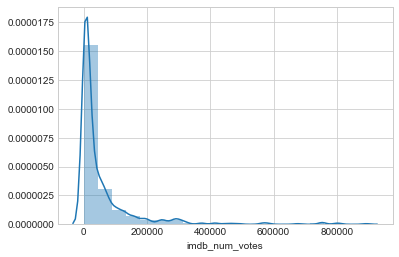

In [9]:
sns.set_style("whitegrid")
sns.distplot(movies_raw.imdb_num_votes, bins=20)

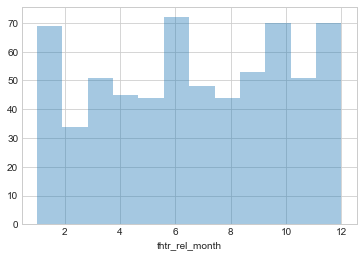

In [10]:
sns.set_style("whitegrid")
sns.distplot(movies_raw.thtr_rel_month, bins=12, kde=False)

In [32]:
movies = movies_raw[['top200_box', 'genre', 'title_type', 'mpaa_rating', 'imdb_rating', 'imdb_num_votes', 
                     'best_pic_nom', 'best_pic_win', 'best_actor_win', 'best_actress_win', 
                     'best_dir_win', 'critics_score', 'audience_score']].copy()
movies = movies.dropna()

In [33]:
# I count best picture nomination as a win too
awards = ['best_pic_nom', 'best_pic_win', 'best_actor_win', 'best_actress_win', 'best_dir_win']
def cal_wins(row):
    wins = 0
    for col in awards:
        if row[col] == 'yes':
            wins += 1
    return wins

movies['wins'] = movies[awards].apply(cal_wins, axis=1)

In [52]:
movies['imdb_num_votes_sd'] = scale(movies['imdb_num_votes'])
# movies['imdb_num_votes_sd'].mean(), movies['imdb_num_votes_sd'].std()
movies['critics_score_sd'] = scale(movies['critics_score'])
movies['audience_score_sd'] = scale(movies['audience_score'])
movies['imdb_rating_sd'] = scale(movies['imdb_rating'])

/Users/apple/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [35]:
# I am not sure how valid this value assignment is, particularly 5 for "unrated"
# movies.mpaa_rating.unique()
movies['mpaa_rating_num'] = movies['mpaa_rating'].map(
    {'G': 0, 'PG': 1, 'PG-13': 2, 'R': 3,  'NC-17': 4, 'Unrated': 5})

In [36]:
movies.head(10).T

,0,1,2,3,4,5,6,7,8,9
top200_box,no,no,no,no,no,no,no,no,no,no
genre,Drama,Drama,Comedy,Drama,Horror,Documentary,Drama,Drama,Documentary,Drama
title_type,Feature Film,Feature Film,Feature Film,Feature Film,Feature Film,Documentary,Feature Film,Feature Film,Documentary,Feature Film
mpaa_rating,R,PG-13,R,PG,R,Unrated,PG-13,R,Unrated,Unrated
imdb_rating,5.5,7.3,7.6,7.2,5.1,7.8,7.2,5.5,7.5,6.6
imdb_num_votes,899,12285,22381,35096,2386,333,5016,2272,880,12496
best_pic_nom,no,no,no,no,no,no,no,no,no,no
best_pic_win,no,no,no,no,no,no,no,no,no,no
best_actor_win,no,no,no,yes,no,no,no,yes,no,no
best_actress_win,no,no,no,no,no,no,no,no,no,no


In [37]:
movies['top200_box'] = movies['top200_box'].map({'yes': 1, 'no': 0})


# Logistic Regression Analysis

* Normalized X (explanatory viarables) products better statistics numbers for interpretation. Therefore the normalized imdb_num_votes_sd will be used for discussion.

As you can see:
* p-value: close to 0 (significant)
* Odds ratio: 1.847863
* 95% confidence intervals for the odds ratios: 1.470504  2.322059

This supports that the number of votes on IMDB is associated with if a movie is in the top 200 box office list.

In [38]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# logistic regression with number of votes on IMDB
lr_v1 = smf.logit(formula = 'top200_box ~ imdb_num_votes', data = movies).fit()
print(lr_v1.summary())

# odd ratios with 95% confidence intervals
params = lr_v1.params
conf = lr_v1.conf_int()
conf['OR'] = params
conf.columns = ['Lower CI', 'Upper CI', 'OR']
print(np.exp(conf))

Optimization terminated successfully.
         Current function value: 0.092889
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             top200_box   No. Observations:                  651
Model:                          Logit   Df Residuals:                      649
Method:                           MLE   Df Model:                            1
Date:                Wed, 28 Mar 2018   Pseudo R-squ.:                  0.1529
Time:                        17:43:44   Log-Likelihood:                -60.471
converged:                       True   LL-Null:                       -71.383
                                        LLR p-value:                 2.989e-06
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.4152      0.350    -12.617      0.000      -5.101      -3.729
imdb_num_votes  5

In [39]:
# logistic regression with number of votes on IMDB (normalized)
lr_v2 = smf.logit(formula = 'top200_box ~ imdb_num_votes_sd', data = movies).fit()
print(lr_v2.summary())

# odd ratios with 95% confidence intervals
params = lr_v2.params
conf = lr_v2.conf_int()
conf['OR'] = params
conf.columns = ['Lower CI', 'Upper CI', 'OR']
print(np.exp(conf))

Optimization terminated successfully.
         Current function value: 0.092889
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             top200_box   No. Observations:                  651
Model:                          Logit   Df Residuals:                      649
Method:                           MLE   Df Model:                            1
Date:                Wed, 28 Mar 2018   Pseudo R-squ.:                  0.1529
Time:                        17:43:44   Log-Likelihood:                -60.471
converged:                       True   LL-Null:                       -71.383
                                        LLR p-value:                 2.989e-06
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -4.0999      0.317    -12.935      0.000      -4.721      -3.479
imdb_num

# Confounding variables

* wins alone p 0.008, but after adding imdb_num_votes_sd then p 0.643
* critics_score_sd, imdb_rating_sd and audience_score_sd by itself are all close but < 0.05, but p becomes very big after adding imdb_num_votes_sd


## Not significant variable

* title_type: all categories are close to 1


In [64]:
model = smf.logit(formula='top200_box ~  wins', data=movies).fit()
print(model.summary())

# odd ratios with 95% confidence intervals
params = model.params
conf = model.conf_int()
conf['OR'] = params
conf.columns = ['Lower CI', 'Upper CI', 'OR']
print(np.exp(conf))

Optimization terminated successfully.
         Current function value: 0.105558
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             top200_box   No. Observations:                  651
Model:                          Logit   Df Residuals:                      649
Method:                           MLE   Df Model:                            1
Date:                Wed, 28 Mar 2018   Pseudo R-squ.:                 0.03733
Time:                        17:58:06   Log-Likelihood:                -68.718
converged:                       True   LL-Null:                       -71.383
                                        LLR p-value:                   0.02098
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.0907      0.324    -12.606      0.000      -4.727      -3.455
wins           0.6108      0.

In [70]:
model = smf.logit(formula='top200_box ~  imdb_num_votes_sd + wins', data=movies).fit()
print(model.summary())

# odd ratios with 95% confidence intervals
params = model.params
conf = model.conf_int()
conf['OR'] = params
conf.columns = ['Lower CI', 'Upper CI', 'OR']
print(np.exp(conf))

Optimization terminated successfully.
         Current function value: 0.092728
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             top200_box   No. Observations:                  651
Model:                          Logit   Df Residuals:                      648
Method:                           MLE   Df Model:                            2
Date:                Wed, 28 Mar 2018   Pseudo R-squ.:                  0.1543
Time:                        18:05:02   Log-Likelihood:                -60.366
converged:                       True   LL-Null:                       -71.383
                                        LLR p-value:                 1.643e-05
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -4.1496      0.338    -12.291      0.000      -4.811      -3.488
imdb_num

In [71]:
model = smf.logit(formula='top200_box ~  imdb_num_votes_sd + critics_score_sd', data=movies).fit()
print(model.summary())

# odd ratios with 95% confidence intervals
params = model.params
conf = model.conf_int()
conf['OR'] = params
conf.columns = ['Lower CI', 'Upper CI', 'OR']
print(np.exp(conf))

Optimization terminated successfully.
         Current function value: 0.091428
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:             top200_box   No. Observations:                  651
Model:                          Logit   Df Residuals:                      648
Method:                           MLE   Df Model:                            2
Date:                Wed, 28 Mar 2018   Pseudo R-squ.:                  0.1662
Time:                        18:05:36   Log-Likelihood:                -59.520
converged:                       True   LL-Null:                       -71.383
                                        LLR p-value:                 7.047e-06
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -4.2103      0.354    -11.905      0.000      -4.904      -3.517
imdb_num

In [72]:
model = smf.logit(formula='top200_box ~  imdb_num_votes_sd + imdb_rating_sd', data=movies).fit()
print(model.summary())

# odd ratios with 95% confidence intervals
params = model.params
conf = model.conf_int()
conf['OR'] = params
conf.columns = ['Lower CI', 'Upper CI', 'OR']
print(np.exp(conf))

Optimization terminated successfully.
         Current function value: 0.092850
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             top200_box   No. Observations:                  651
Model:                          Logit   Df Residuals:                      648
Method:                           MLE   Df Model:                            2
Date:                Wed, 28 Mar 2018   Pseudo R-squ.:                  0.1532
Time:                        18:05:37   Log-Likelihood:                -60.446
converged:                       True   LL-Null:                       -71.383
                                        LLR p-value:                 1.779e-05
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -4.1050      0.319    -12.866      0.000      -4.730      -3.480
imdb_num

In [69]:
model = smf.logit(formula='top200_box ~  imdb_num_votes_sd + audience_score_sd', data=movies).fit()
print(model.summary())

# odd ratios with 95% confidence intervals
params = model.params
conf = model.conf_int()
conf['OR'] = params
conf.columns = ['Lower CI', 'Upper CI', 'OR']
print(np.exp(conf))

Optimization terminated successfully.
         Current function value: 0.092473
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             top200_box   No. Observations:                  651
Model:                          Logit   Df Residuals:                      648
Method:                           MLE   Df Model:                            2
Date:                Wed, 28 Mar 2018   Pseudo R-squ.:                  0.1567
Time:                        18:03:51   Log-Likelihood:                -60.200
converged:                       True   LL-Null:                       -71.383
                                        LLR p-value:                 1.391e-05
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -4.1366      0.330    -12.549      0.000      -4.783      -3.490
imdb_num

In [66]:
model = smf.logit(formula='top200_box ~  C(title_type)', data=movies).fit()
print(model.summary())

# odd ratios with 95% confidence intervals
params = model.params
conf = model.conf_int()
conf['OR'] = params
conf.columns = ['Lower CI', 'Upper CI', 'OR']
print(np.exp(conf))

         Current function value: 0.107396
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             top200_box   No. Observations:                  651
Model:                          Logit   Df Residuals:                      648
Method:                           MLE   Df Model:                            2
Date:                Wed, 28 Mar 2018   Pseudo R-squ.:                 0.02057
Time:                        18:01:04   Log-Likelihood:                -69.915
converged:                      False   LL-Null:                       -71.383
                                        LLR p-value:                    0.2303
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -17.1592    717.603     -0.024      0.981   -1423.635    1389.317
C(title_

/Users/apple/anaconda3/envs/deep/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/anaconda3/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


In [47]:
# from sklearn.preprocessing import LabelEncoder

# lb_make = LabelEncoder()
# movies['genre_code'] = lb_make.fit_transform(movies['genre'])
# movies.head().T

# model = smf.logit(formula='top200_box ~ C(genre_code)', data=movies).fit()
# print(model.summary())

# # odd ratios with 95% confidence intervals
# params = model.params
# conf = model.conf_int()
# conf['OR'] = params
# conf.columns = ['Lower CI', 'Upper CI', 'OR']
# print(np.exp(conf))

In [73]:
model = smf.logit(
    formula='top200_box ~ imdb_num_votes_sd + imdb_rating_sd + critics_score_sd + audience_score_sd + C(title_type)'
                  , data=movies).fit()
print(model.summary())

# odd ratios with 95% confidence intervals
params = model.params
conf = model.conf_int()
conf['OR'] = params
conf.columns = ['Lower CI', 'Upper CI', 'OR']
print(np.exp(conf))

         Current function value: 0.088133
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             top200_box   No. Observations:                  651
Model:                          Logit   Df Residuals:                      644
Method:                           MLE   Df Model:                            6
Date:                Wed, 28 Mar 2018   Pseudo R-squ.:                  0.1962
Time:                        18:06:40   Log-Likelihood:                -57.375
converged:                      False   LL-Null:                       -71.383
                                        LLR p-value:                 9.332e-05
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -25.5465   3.97e+04     -0.001      0.999   -7.78e+04    7.78e+04
C(title_

/Users/apple/anaconda3/envs/deep/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/anaconda3/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
